<a href="https://colab.research.google.com/github/skylerlewis/nwca-wetland-remote-sensing/blob/main/nwca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install packages (these are the packages that are not available on the Google cloud servers)

In [2]:
# install packages in the virtual environment
# if there are errors, force restart the environment (factory reset runtime)
!pip install -q pandas fiona shapely pyproj rtree pygeos #--upgrade --force-reinstall
!pip install -q geopandas #--upgrade --force-reinstall
!pip install -q rasterio rioxarray
!pip install -q -U PyDrive

     |████████████████████████████████| 15.4MB 191kB/s 
     |████████████████████████████████| 6.6MB 41.9MB/s 
     |████████████████████████████████| 1.0MB 36.5MB/s 
     |████████████████████████████████| 2.0MB 18.3MB/s 
     |████████████████████████████████| 1.0MB 33.8MB/s 
     |████████████████████████████████| 19.3MB 1.4MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [3]:
# setup for accessing files via Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user() # opens auth prompt the first time it's run
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def file_from_gdrive(filename, driveid):
    downloaded = drive.CreateFile({"id": driveid}) 
    downloaded.GetContentFile(filename)
    return filename

# mount files from google drive (after running, they will be accessible by filename without any path prefix)
file_from_gdrive("Site_comparison_2011_2016.csv", "1PoYS_fbE1lYwi3ydbpXKkuP8YqoBFjnf")
file_from_gdrive("README.csv", "1G5l8L2FgM0EebEKbjy06OWdsfGs47i3c")
file_from_gdrive("Aggr_Ecoregions_2015.zip", "1UqUM1mrj6qptAxSY8c1OGc3zRP_p7bVM")
file_from_gdrive("SubDataset_NWCA_2011.csv", "1QFbR0NoFo7go9hXp690yvb1_G-FjJTUV")

# alternately, mount google drive and access via "/content/drive/MyDrive/nwca/filename..."

def unzip_shapefile(filename):
    import io
    from fiona.io import ZipMemoryFile
    zipshp = io.BytesIO(open(filename, "rb").read())
    with (ZipMemoryFile(zipshp)) as memfile:
        with memfile.open() as src:
            crs = src.crs
            gdf = gpd.GeoDataFrame.from_features(src, crs=crs)
    return gdf

# Package imports

In [4]:
# basics
import os
import datetime as dt
from functools import reduce
import urllib
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# geospatial
import shapely
import geopandas as gpd 
import rasterio as rio
import xarray as xr 
import rioxarray
global_crs = "EPSG:5070" # NAD83 CONUS ALBERS

# statistical packages
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_squared_log_error

from pandas import IndexSlice as idx
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", '{:0.2f}'.format)

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Custom functions

In [5]:
# function to keep only intersecting features
def subset_by_sindex(target_features, by_features, predicate="intersects") -> gpd.GeoDataFrame:
    """ Uses one geodataframe/geometry to query another. 
            Predicate is one of ['intersects', 'within', 'contains', 'overlaps', 'crosses', 'touches'] """
    inp, res = by_features.sindex.query_bulk(target_features.geometry, predicate=predicate)
    return target_features[np.isin(np.arange(0, len(target_features)), inp)]

# function to generate matplotlib colormap from list
def gen_cmap(palette: list) -> mpl.colors.LinearSegmentedColormap:
    """ Returns a matplotlib colormap given a list of color strings."""
    colors = [(i / (len(palette) - 1), x) for i, x in enumerate(palette)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", colors, len(palette))
    return cmap

def make_ellipse(x: np.ndarray, y: np.ndarray, n_std=3.0, type="confidence", **kwargs) -> mpl.patches.Ellipse:
    from scipy.stats import norm, chi2
    # calculate ellipse dimensions
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    if type == "confidence":
        # confidence ellipse
        q = 2 * norm.cdf(n_std) - 1
        r2 = chi2.ppf(q, 2)
        width, height = 2 * np.sqrt(vals * r2)
    elif type == "error":
        # error ellipse
        width, height = 2 * n_std * np.sqrt(vals)
    #print(width, height, theta)
    # center of ellipse
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    # create ellipse
    ellipse = mpl.patches.Ellipse(xy=(mean_x, mean_y), width=width, height=height, angle=theta, **kwargs)
    return ellipse

def flatten_columns(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d.columns = ['_'.join(tup).rstrip('_') for tup in d.columns.values]
    return d

def quick_vif(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor 
    v = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return pd.Series(v, index = df.columns)

def quick_skedplot(modelfit, title=None):
    pred_mod = modelfit.predict()
    res_mod = modelfit.resid
    fig, ax = plt.subplots(figsize=(10,6))
    x = pred_mod
    y = res_mod
    if title is None:
        plt.title("Homoskedasticity Test Plot")
    else:
        plt.title(title)
    plt.axhline(y=0, color="black", linestyle=":") 
    ax.scatter(x, y)
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Residuals")  
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x1, loc: "{:,}".format(int(x1))))
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y1, loc: "{:,}".format(int(y1))))
    sns.despine(trim=True)
    plt.show()

def quick_skedtest(models: list, labels=None):
    from statsmodels.compat import lzip
    from statsmodels.stats.diagnostic import het_breuschpagan
    test_names = ['LMS', 'P(LMS)', 'F', 'P(F)']
    t = []
    for m in models:
        results = het_breuschpagan(m.resid, m.model.exog)
        t.append([x for x in results])
        #print(lzip(test_names, results))
    if labels is None:
        return pd.DataFrame(t, columns=test_names)
    else:
        return pd.DataFrame(t, columns=test_names, index=labels)

def plot_actual_vs_predicted(actual: np.ndarray, predicted: np.ndarray, n_std: int = 2, **kwargs) -> sns.axisgrid.FacetGrid:
    g = sns.jointplot(x=actual, y=predicted, **kwargs)
    std_min = min(g.ax_joint.get_xlim() + g.ax_joint.get_ylim())
    std_max = max(g.ax_joint.get_xlim() + g.ax_joint.get_ylim())
    std_lim = (std_min, std_max)
    g.ax_joint.set_xlim(std_lim)
    g.ax_joint.set_ylim(std_lim)
    g.ax_marg_x.set_xlim(std_lim)
    g.ax_marg_y.set_ylim(std_lim)
    sns.despine(trim=True, ax=g.ax_joint)
    sns.despine(trim=True, ax=g.ax_marg_x, left=True)
    sns.despine(trim=True, ax=g.ax_marg_y, bottom=True)
    sns.lineplot(ax=g.ax_joint, color="black", linestyle=":", x=std_lim, y=std_lim)
    g.ax_joint.add_patch(make_ellipse(x=actual, y=predicted, 
            facecolor="#5799c6", alpha=0.2, type="error", n_std=n_std))
    return g

# Import site traits (NWCA) data from CSV

In [28]:
# import data
sites = pd.read_csv("Site_comparison_2011_2016.csv")
readme = pd.read_csv("README.csv")

# convert to pandas datafrmae with multiindex (varname, year) derived from readme file
if (sites.columns == readme["trait"]).all():
    sites.columns = pd.MultiIndex.from_tuples(zip(readme["varname"], readme["year"]), names=["varname", "year"])
else:
    raise ValueError("Make sure the list of variables in both files matches!")

# create ID for the 
# sites["id"] = sites[("UID", "2011")].astype(str) + "-" + sites[("UID", "2016")].astype(str)
# sites = sites.set_index("id")
sites = sites.set_index([("UID", "2011"), ("UID", "2016")]).rename_axis(["UID11", "UID16"])

# cast species richness to integer
#sites["NSPP"] = sites["NSPP"].astype(pd.Int64Dtype())

# create order for wetland types
wetlandtypes = ["PFO", "PSS", "PEM", "PUBPAB", "E2SS", "E2EM"]
typecolors = ["#55AD89", "#C3BC3F", "#FFAE34", "#BAA094", "#8CC2CA", "#6388B4"]
sites[("WetlandType", "2011")] = ["PFO" if x=="PF" else x for x in sites[("WetlandType", "2011")]]
sites[("WetlandType", "2016")] = ["PFO" if x=="PF" else x for x in sites[("WetlandType", "2016")]]
sites[("WetlandType", "2011")] = sites[("WetlandType", "2011")].astype("category").cat.set_categories(wetlandtypes)
sites[("WetlandType", "2016")] = sites[("WetlandType", "2016")].astype("category").cat.set_categories(wetlandtypes)

# wetland general categories
wetlandcats = ["EH", "EW", "PRLH", "PRLW"] # Estuarine herbaceous & woody, Palustrine/Riverine/Lacustrine herbaceous & woody
catcolors = ["#8CC2CA", "#6388B4", "#C3BC3F", "#55AD89"]
sites[("WetlandCat", "2011")] = ["EH" if x=="E2EM" else "EW" if x=="E2SS" else "PRLH" if x in ["PEM", "PUBPAB"] else "PRLW" if x in ["PFO", "PSS"] else None for x in sites[("WetlandType", "2011")]]
sites[("WetlandCat", "2011")] = sites[("WetlandCat", "2011")].astype("category").cat.set_categories(wetlandcats)
sites[("WetlandCat", "2016")] = ["EH" if x=="E2EM" else "EW" if x=="E2SS" else "PRLH" if x in ["PEM", "PUBPAB"] else "PRLW" if x in ["PFO", "PSS"] else None for x in sites[("WetlandType", "2011")]]
sites[("WetlandCat", "2016")] = sites[("WetlandCat", "2016")].astype("category").cat.set_categories(wetlandcats)

# create dummies for estuarine and woody
#sites["WetlandCat"].applymap(lambda x: x[-1]=="W")
#sites["WetlandCat"].applymap(lambda x: x[:-1]=="E")
for yr in ["2011", "2016"]:
    sites[("d_estuarine", yr)] = np.where(sites[("WetlandCat", yr)].apply(lambda x: x[:-1]=="E"), 1, 0)
    sites[("d_woody", yr)] = np.where(sites[("WetlandCat", yr)].apply(lambda x: x[-1]=="W"), 1, 0)

# import the second dataset
ds11 = pd.read_csv("SubDataset_NWCA_2011.csv").set_index("UID").rename_axis("UID11")
ds11.columns = pd.MultiIndex.from_tuples([(x, "2011") for x in ds11.columns])
sites = sites.join(ds11, how="left")

# create dummies for disturbance level, and also change it to an ordered category
sites[("REF_NWCA", "2011")] = sites[("REF_NWCA", "2011")].astype("category").cat.set_categories(["L", "I", "M"])#.cat.rename_categories(["Least", "Intermediate", "Most"])
sites[("d_disturb_L", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="L", 1, 0)
sites[("d_disturb_I", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="I", 1, 0)
sites[("d_disturb_M", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="M", 1, 0)

sites

varname      Latitude Longitude Latitude  ... d_disturb_L d_disturb_I d_disturb_M
year             2011      2011     2016  ...        2011        2011        2011
UID11 UID16                               ...                                    
2610  204253    30.15    -85.04    30.15  ...           0           0           1
2611  201075    32.53    -80.45    32.53  ...           1           0           0
2669  197720    29.66    -81.77    29.66  ...           0           0           1
2791  200920    32.39    -80.66    32.39  ...           0           1           0
2812  197200    30.26    -87.73    30.26  ...           1           0           0
...               ...       ...      ...  ...         ...         ...         ...
5910  209080    47.55    -95.59    47.55  ...           0           1           0
5911  204792    44.86    -72.05    44.86  ...           0           1           0
5912  202530    43.91    -73.10    43.91  ...           0           0           1
5915  202530    43.91    -73.10    43.91  ...           0           0           1
6146  201931    31.56    -81.67    31.56  ...           0           1           0

[293 rows x 113 columns]

In [29]:
# example reshaping
sites.stack()

# examples subsetting the data by year

# data2011 = sites.loc[:, idx[:, "2011"]]
# data2011.columns = [x[0] for x in data2011.columns]
data2011 = sites.stack().loc[idx[:, :, "2011"]]

# data2016 = sites.loc[:, idx[:, "2016"]]
# data2016.columns = [x[0] for x in data2016.columns]
data2016 = sites.stack().loc[idx[:, :, "2016"]]

# Spatial data setup

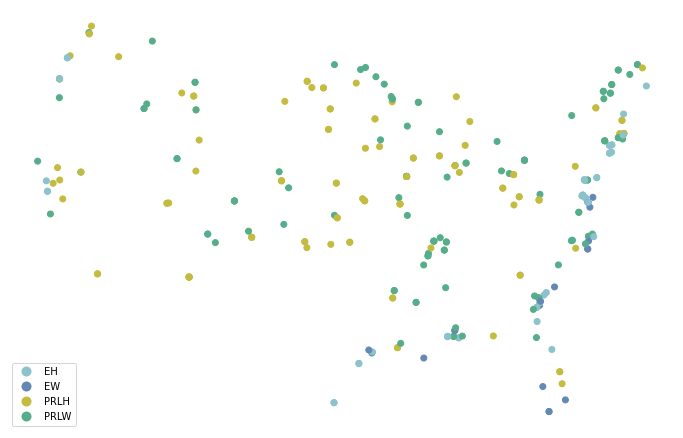

In [30]:
# make geodataframe
sites_gdf = gpd.GeoDataFrame(sites.copy(), geometry=gpd.points_from_xy(sites[("Longitude", "2016")], sites[("Latitude", "2016")]))
# set existing CRS
sites_gdf[("geometry", "")].set_crs("EPSG:4269", inplace=True)
#sites_gdf.set_geometry(("geometry", ""), inplace=True)
# reproject
sites_gdf[("geometry", "")] = sites_gdf[("geometry", "")].to_crs(global_crs)
# set new CRS
#sites_gdf[("geometry", "")].set_crs(global_crs, inplace=True)
sites_gdf.set_geometry(("geometry", ""), inplace=True)

# plot result
fig, ax = plt.subplots()
sites_gdf.plot(column=("WetlandCat","2016"), legend=True, cmap=gen_cmap(catcolors), ax=ax)
ax.axis("off")
fig.set_size_inches(12, 12)
plt.show()

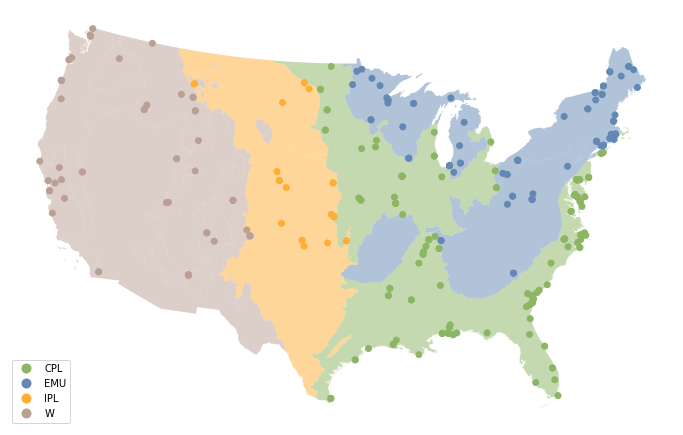

In [31]:
# get ecoregions, convert from 9-level to 4-level for NWCA
#ecoregions = gpd.read_file(os.path.join("data", "ecoregions", "Aggr_Ecoregions_2015.shp")).to_crs(global_crs)
ecoregions = unzip_shapefile("Aggr_Ecoregions_2015.zip").to_crs(global_crs)
region_names = ["CPL", "EMU", "IPL", "W"]
region_colors = ["#8CB564", "#6388B4", "#FFAE34", "#BAA094"]
ecoregions["WSA4"] = ["EMU" if x in ["NAP", "SAP", "UMW"]
                        else "IPL" if x in ["NPL", "SPL"]
                        else "W" if x in ["XER", "WMT"]
                        else "CPL" for x in ecoregions["WSA9"]]
ecoregions["WSA4"] = ecoregions["WSA4"].astype("category").cat.set_categories(region_names)
points = gpd.GeoDataFrame(flatten_columns(gpd.GeoDataFrame(sites_gdf.geometry.copy())), crs=sites_gdf.geometry.crs)
site_regions = gpd.sjoin(points, ecoregions, how="left", op="within")

# plot ecoregions by site
fig, ax = plt.subplots()
ecoregions.plot(column="WSA4", ax=ax, alpha=0.5, cmap=gen_cmap(region_colors))
site_regions.plot(column="WSA4", ax=ax, legend=True, cmap=gen_cmap(region_colors))
ax.axis("off")
fig.set_size_inches(12, 12)
plt.show()

# add to site table
sites["ecoregion"] = site_regions["WSA4"]

In [11]:
# TERRACLIMATE
# catalog: http://thredds.northwestknowledge.net:8080/thredds/catalog/TERRACLIMATE_ALL/data/catalog.html

def extract_values_to_points(ds: xr.Dataset, varname: str, pts: gpd.GeoSeries) -> pd.DataFrame:
    def timeseries_from_raster(pt: shapely.geometry.Point) -> pd.Series:
        return ds.sel(lon=pt.x, lat=pt.y, method="nearest").to_dataframe()[varname]
    return pts.apply(timeseries_from_raster).stack().rename(varname)

# define parameters of files to get
tc_vars = ["ppt", "pet", "aet", "def", "PDSI"] 
tc_years = [2011, 2016]
dirname = "tc"

# get buffers from which to extract points
#buffers = sites_gdf.buffer(distance=40).rename("geometry").reset_index().to_crs("EPSG:4326")
pts = gpd.GeoDataFrame(sites_gdf[("geometry", "")].to_crs("EPSG:4326"))["geometry"]

d = {}
# get files from terraclimate server
if not os.path.exists(dirname):
    os.mkdir(dirname)
for v in tc_vars:
    for y in tc_years:
        url = f"http://thredds.northwestknowledge.net:8080/thredds/fileServer/TERRACLIMATE_ALL/data/TerraClimate_{v}_{y}.nc"
        destname = os.path.join(dirname, f"TerraClimate_{v}_{y}.nc")
        if not os.path.exists(destname):
            urllib.request.urlretrieve(url, destname)
        with xr.open_dataset(destname).rio.write_crs("EPSG:4326").rio.set_spatial_dims(x_dim="lon", y_dim="lat") as ds:
            d[(v, y)] = extract_values_to_points(ds=ds, varname=v, pts=pts)

# out_df = pd.concat(d, axis="columns").rename_axis(["tc_var", "year"], axis="columns")
extracted = pd.concat(d, names=["varname", "year"]).rename("value")

df_tc = (extracted
        .groupby(["varname", "year", "UID11", "UID16"])
        .agg(["min", "mean", "max"])
        .rename_axis("subvar", axis="columns")
        .stack("subvar")
        .unstack(["varname", "subvar"])
        .pipe(flatten_columns)
        .rename_axis("variable", axis="columns")
        .reset_index("year")
        .assign(year = lambda d: d["year"].astype("str"))
        .set_index("year", append=True)
        .unstack("year")
        )

# join the terraclimate data to the sites dataframe
sites = sites.join(df_tc, how="left")

# Exploration of traits data

In [33]:
vars_to_plot = [
        "NSPP", "ShannonDiv", 
        "CN_Ratio", #"CN_Variance", 
        "AnaerobicTol_Mean", #"AnaerobicTol_Variance", 
        "SLA_Mean", #"SLA_Variance", 
        #"XN_ALIENSPP", 
        "XRCOV_ALIENSPP", 
        #"XN_NATSPP", 
        "XRCOV_NATSPP", 
        "PCTN_HERB", 
]

#d = sites.stack(["year"])[["NSPP", "ShannonDiv"]].reset_index("year")
#g = sns.PairGrid(d, hue="year")
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
#g.add_legend()

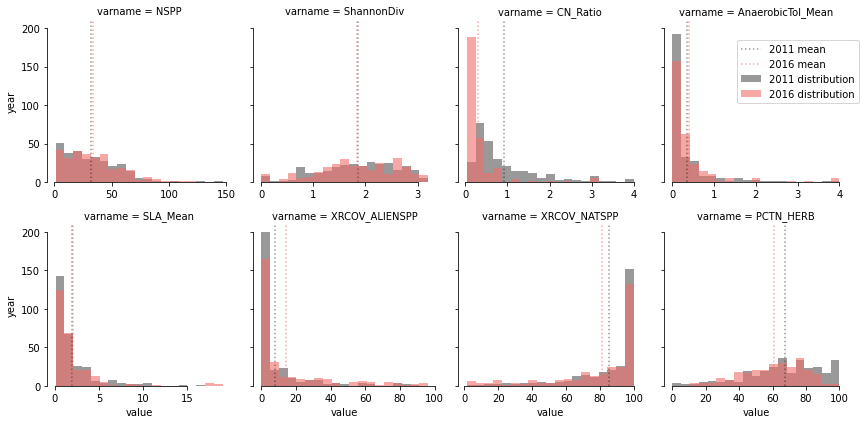

In [34]:
def plot_hist_grouped(x, hue, n_bins=10, color=None, palette=None, **kwargs):
    bins = np.linspace(x.min(), x.max(), n_bins)
    for i, (_, x_i) in enumerate(x.groupby(hue)):
        x_mean = x_i.mean()
        #x_std = np.std(x_i)
        #x_ci_low = x_mean - x_std
        #x_ci_high = x_mean + x_std
        if palette:
            #plt.axvspan(xmin=x_ci_low, xmax=x_ci_high, alpha=0.1, color=palette[i])
            plt.hist(x_i, bins, color=palette[i], **kwargs)
            plt.axvline(x=x_mean, linestyle=":", color=palette[i])
        else:
            #plt.axvspan(xmin=x_ci_low, xmax=x_ci_high, alpha=0.1)
            plt.hist(x_i, bins, **kwargs)
            plt.axvline(x=x_mean, linestyle=":")


d = (sites
        .loc[:, idx[:, ("2011", "2016")]]
        .stack("year")
        [vars_to_plot]
        .stack("varname")
        .rename("value")
        .reset_index(["varname", "year"])
        )
g = sns.FacetGrid(data=d, col="varname", col_wrap=4, sharex=False)
g.map(plot_hist_grouped, "value", "year", n_bins=20, palette=["#00000066", "#EF6F6A99"])
#g.add_legend()
g.fig.legend(["2011 mean", "2016 mean", "2011 distribution", "2016 distribution"]).set_bbox_to_anchor((1, 0.9))
sns.despine(trim=True)
plt.show()

# imrpovement: kde histograms, colored by wetland type, rows=year, columns=vars

In [35]:
# right-skew (consider log): NSPP, XN_ALIENSPP, XN_NATSPP, SLA_Mean, AnaerobicTol_Mean, CN_Ratio
for v in ["NSPP", "SLA_Mean", "AnaerobicTol_Mean", "CN_Ratio", "XN_NATSPP", "XN_ALIENSPP", "XRCOV_ALIENSPP", ]:
    for y in ["2011", "2016"]:
        sites[(f"log_{v}", y)] = np.where(sites[v, y]>0, np.log(sites[v, y]), np.nan)
    sites[(f"log_{v}", "DIFF")] = sites[(f"log_{v}", "2016")] - sites[(f"log_{v}", "2011")]
#   for v in ["PCTN_HERB", "ShannonDiv", "XRCOV_NATSPP", ]:
#       for y in ["2011", "2016"]:
#           sites[(f"exp_{v}", y)] = np.exp(sites[v, y])
#       sites[(f"exp_{v}", "DIFF")] = sites[(f"exp_{v}", "2016")] - sites[(f"exp_{v}", "2011")]

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


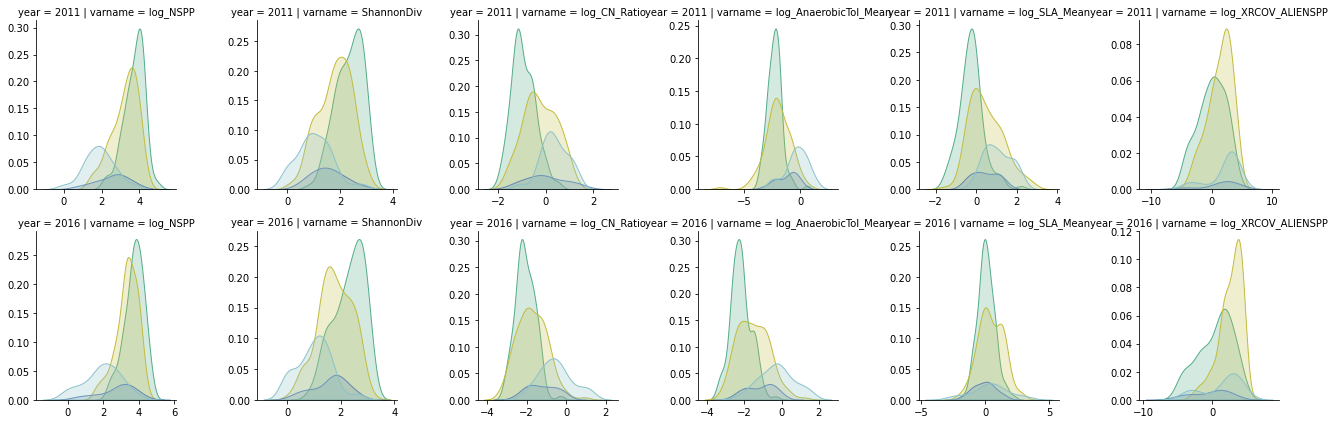

In [36]:
vars_to_plot2 = ["log_NSPP", "ShannonDiv", "log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean", "log_XRCOV_ALIENSPP"]
d = (sites
        .loc[:, idx[:, ("2011", "2016")]]
        .stack("year")
        .set_index(["WetlandCat"], append=True)
        [vars_to_plot2]
        .stack("varname")
        .rename("value")
        .reset_index(["varname", "year", "WetlandCat"])
        .dropna()
        )

d["varname"] = d["varname"].astype("category").cat.set_categories(vars_to_plot2)
d["WetlandCat"] = d["WetlandCat"].astype("category").cat.set_categories(wetlandcats)

g = sns.FacetGrid(data=d, col="varname", row="year", sharex=False, sharey=False)
g.map_dataframe(sns.kdeplot, x="value", hue="WetlandCat", palette=catcolors, shade=True)
g.add_legend()
sns.despine()
#for a in g.axes.flatten():
#    a.set_xticks(np.exp(a.get_xticks()[:-2]))
plt.show()

# horizontal = 2011, vertical = 2016 (above diagonal = increase, below diagonal = decrease )
# update to use proper category order

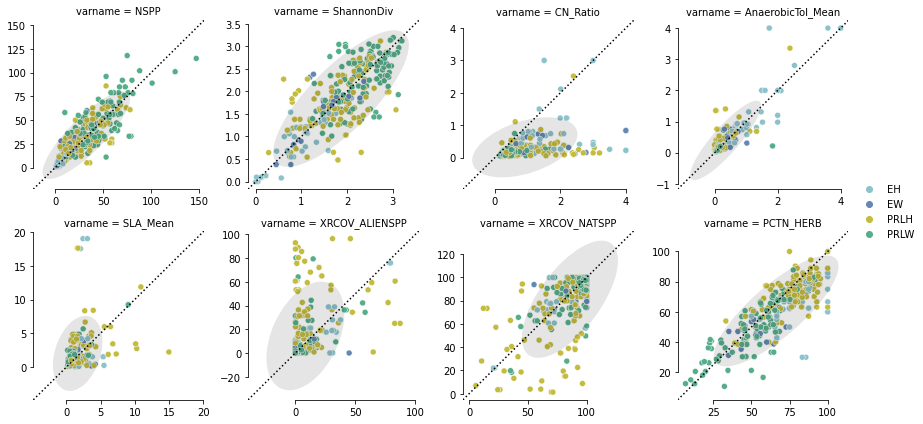

In [37]:
def plot_twoway_symmetrical(*args, **kwargs):
    sp = sns.scatterplot(*args, **kwargs)
    ax = sp.axes
    if "data" in kwargs:
        x = kwargs["data"][kwargs["x"]]
        y = kwargs["data"][kwargs["y"]]
    else:
        x = kwargs["x"]
        y = kwargs["y"]
    ax.add_patch(make_ellipse(x=x, y=y, 
        facecolor="black", alpha=0.1, type="error", n_std=2))
    std_min = min(ax.get_xlim() + ax.get_ylim())
    std_max = max(ax.get_xlim() + ax.get_ylim())
    std_lim = (std_min, std_max)
    ax.set_xlim(std_lim)
    ax.set_ylim(std_lim)
    #ax.set_xticks(ax.get_yticks(minor=False), minor=False)
    #ax.set_xticklabels(ax.get_xticklabels(minor=False), minor=False)
    sns.lineplot(ax=ax, color="black", linestyle=":", x=std_lim, y=std_lim)
    sns.despine(trim=True, ax=ax)
    return sp

d = (sites
        .loc[:, idx[:, ("2011", "2016")]]
        .stack("year")
        .set_index(["WetlandCat"], append=True)
        [vars_to_plot]
        .unstack("year")
        .stack("varname")
        .reset_index(["varname", "WetlandCat"])
        .dropna()
        )

d["varname"] = d["varname"].astype("category").cat.set_categories(vars_to_plot)
d["WetlandCat"] = d["WetlandCat"].astype("category").cat.set_categories(wetlandcats)

g = sns.FacetGrid(data=d, col="varname", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(plot_twoway_symmetrical, x="2011", y="2016", hue="WetlandCat", ci=False, palette=catcolors)
g.add_legend()
#map(lambda a: a.set_xlim(0), g.axes)
#map(lambda a: a.set_ylim(0), g.axes)
plt.show()

# horizontal = 2011, vertical = 2016 (above diagonal = increase, below diagonal = decrease )
# update to use proper category order

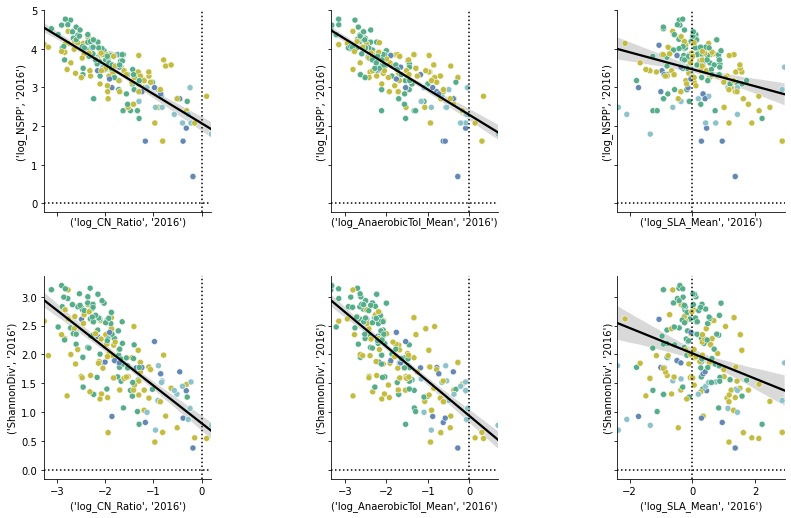

In [38]:
# C:N ratio, Anaerobic tolerance and SLA (specific leaf area)) correlate with changes in species richness or Shannon diversity

y_vars = ["log_NSPP", "ShannonDiv"]
x_vars = ["log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean"]
z_vars = ["WetlandCat"]
d = sites[y_vars + x_vars + z_vars].dropna()

fig, axs = plt.subplots(len(y_vars), len(x_vars), sharex="col", sharey="row")
for i, y in enumerate(y_vars):
    for j, x in enumerate(x_vars):
        sns.regplot(ax=axs[i, j], x=d[(x, "2016")], y=d[(y, "2016")], line_kws={"color": "black"}, scatter=False)
        sns.scatterplot(ax=axs[i, j], x=d[(x, "2016")], y=d[(y, "2016")], hue=d[("WetlandCat", "2016")], legend=False, palette=catcolors)
        axs[i, j].axhline(y=0, color="black", linestyle=":")
        axs[i, j].axvline(x=0, color="black", linestyle=":")
sns.despine()
plt.tight_layout()
fig.set_size_inches(12,8)
plt.show()

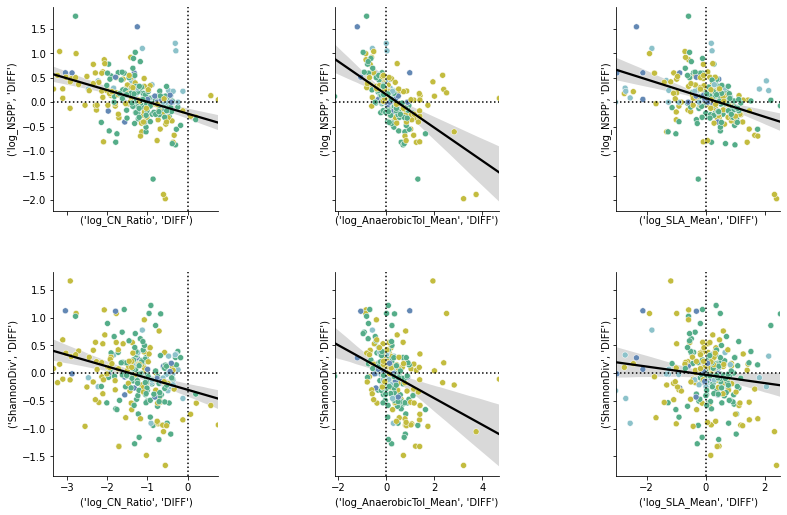

In [39]:
# C:N ratio, Anaerobic tolerance and SLA (specific leaf area)) correlate with changes in species richness or Shannon diversity

y_vars = ["log_NSPP", "ShannonDiv"]
x_vars = ["log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean"]
z_vars = ["WetlandCat"]
d = sites[y_vars + x_vars + z_vars].dropna()

fig, axs = plt.subplots(len(y_vars), len(x_vars), sharex="col", sharey="row")
for i, y in enumerate(y_vars):
    for j, x in enumerate(x_vars):
        sns.regplot(ax=axs[i, j], x=d[(x, "DIFF")], y=d[(y, "DIFF")], line_kws={"color": "black"}, scatter=False)
        sns.scatterplot(ax=axs[i, j], x=d[(x, "DIFF")], y=d[(y, "DIFF")], hue=d[("WetlandCat", "2016")], legend=False, palette=catcolors)
        axs[i, j].axhline(y=0, color="black", linestyle=":")
        axs[i, j].axvline(x=0, color="black", linestyle=":")
sns.despine()
plt.tight_layout()
fig.set_size_inches(12,8)
plt.show()

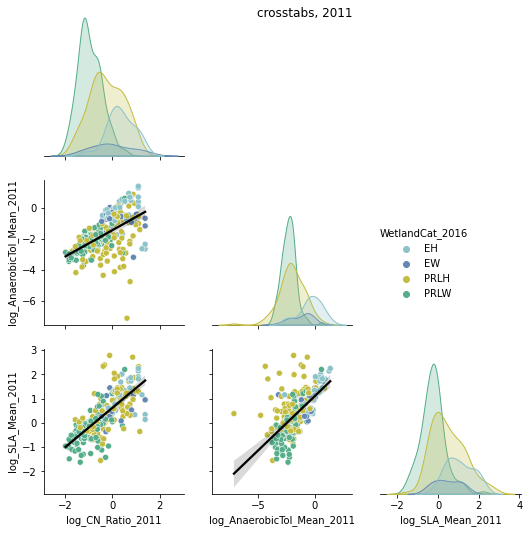

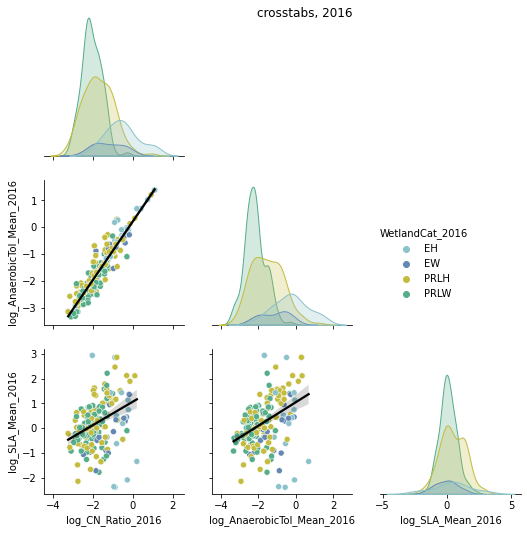

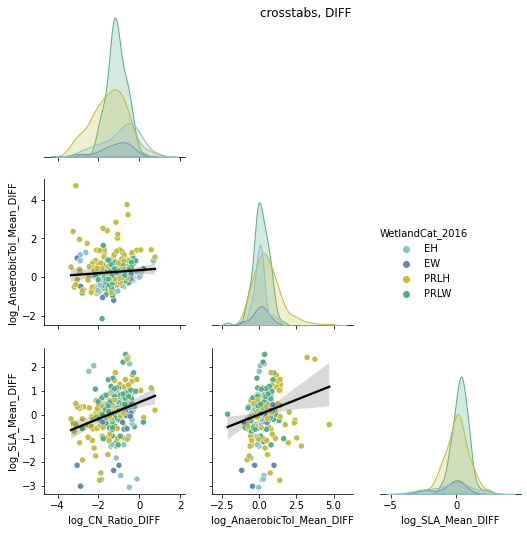

In [40]:
#def plot_diag(*args, **kwargs):
#    g = sns.kdeplot(*args, **kwargs)
#    g.axes.axvline(x=0, color="black", linestyle=":")
#    return g

def plot_offdiag(hue, palette, *args, **kwargs):
    g = sns.scatterplot(x=kwargs["x"], y=kwargs["y"], hue=hue, palette=palette)
    h = sns.regplot(x=kwargs["x"], y=kwargs["y"], scatter=False, ax=g.axes, color="black")
#    g.axes.axhline(y=0, color="black", linestyle=":")
#    g.axes.axvline(x=0, color="black", linestyle=":")
    return g

for yr in ["2011", "2016", "DIFF"]:
    d = flatten_columns(sites)[["WetlandCat_2016", f"log_CN_Ratio_{yr}", f"log_AnaerobicTol_Mean_{yr}", f"log_SLA_Mean_{yr}"]] #, f"log_NSPP_{yr}", f"ShannonDiv_{yr}"]] #.dropna()
    #g = sns.pairplot(d, corner=True, kind="scatter", diag_kind="kde", hue="WetlandCat_2016", palette=catcolors)
    g = sns.PairGrid(d, corner=True, hue="WetlandCat_2016")
#    g.map_diag(plot_diag, hue=d["WetlandCat_2016"], palette=catcolors, fill=True)
    g.map_diag(sns.kdeplot, hue=d["WetlandCat_2016"], palette=catcolors, fill=True)
    g.map_offdiag(plot_offdiag, hue=d["WetlandCat_2016"], palette=catcolors)
    g.fig.suptitle(f"crosstabs, {yr}")
    g.add_legend()
    g._legend.set_bbox_to_anchor(((3/4), (1/2)))
    plt.show()
# note high correlation between anaerobic tol and CN ratio in 2016

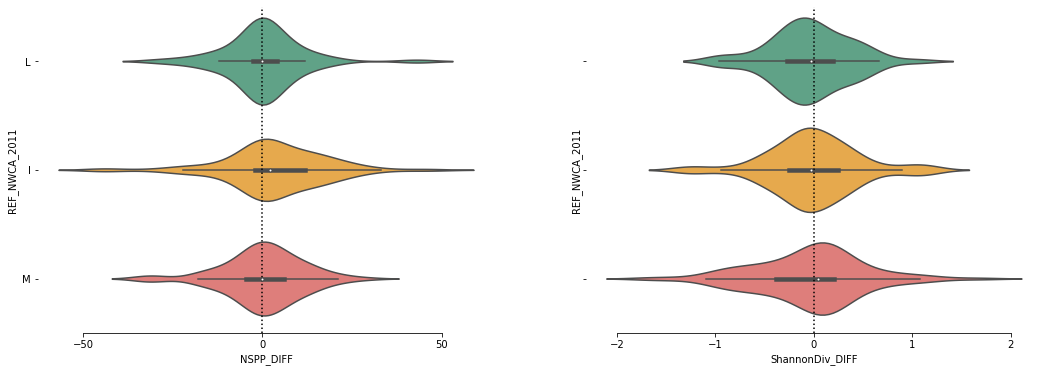

In [41]:
fig, ax = plt.subplots(1, 2, sharey=True)
palette = ["#55AD89", "#FFAE34", "#EF6F6A"]
sns.violinplot(data=flatten_columns(sites), x="NSPP_DIFF", y="REF_NWCA_2011", palette=palette, ax=ax[0])
sns.violinplot(data=flatten_columns(sites), x="ShannonDiv_DIFF", y="REF_NWCA_2011", palette=palette, ax=ax[1])
ax[0].axvline(0, c="black", ls=":")
ax[1].axvline(0, c="black", ls=":")
sns.despine(trim=True, left=True)
fig.set_size_inches(18,6)

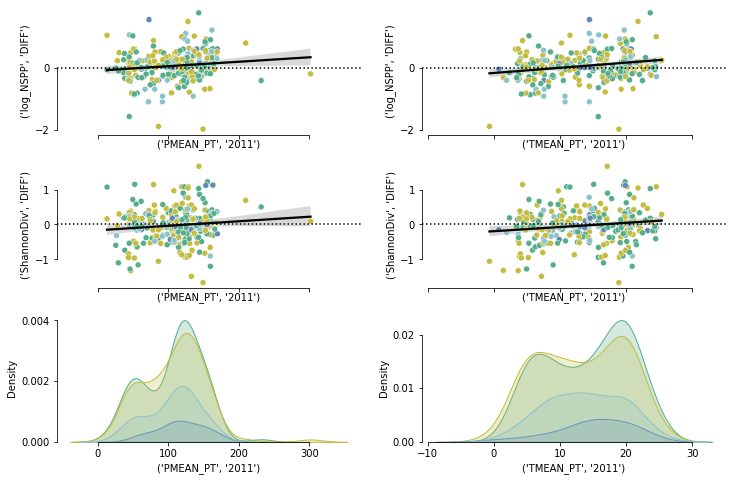

In [42]:
# temperature and precipitation

y_vars = ["log_NSPP", "ShannonDiv"]
x_vars = ["PMEAN_PT", "TMEAN_PT"]
z_vars = ["WetlandCat"]
d = sites[y_vars + x_vars + z_vars].dropna()

fig, axs = plt.subplots(len(y_vars) + 1, len(x_vars), sharex="col", sharey=False)
for j, x in enumerate(x_vars):
    for i, y in enumerate(y_vars):
        sns.regplot(ax=axs[i, j], x=d[(x, "2011")], y=d[(y, "DIFF")], line_kws={"color": "black"}, scatter=False)
        sns.scatterplot(ax=axs[i, j], x=d[(x, "2011")], y=d[(y, "DIFF")], hue=d[("WetlandCat", "2016")], legend=False, palette=catcolors)
        axs[i, j].axhline(y=0, color="black", linestyle=":")
    sns.kdeplot(ax=axs[-1, j], x=d[(x, "2011")], hue=d[("WetlandCat", "2016")], palette=catcolors, legend=False, shade=True)
sns.despine(trim=True)
#plt.tight_layout()
fig.set_size_inches(12,8)
plt.show()

## Exploratory regression (1)

In [43]:
if False:
    for y_var in [("log_NSPP", "DIFF"), ("ShannonDiv", "DIFF")]:
        X_vars = [
            #("log_CN_Ratio", "2011"), ("log_AnaerobicTol_Mean", "2011"), ("log_SLA_Mean", "2011"),
            ("log_CN_Ratio", "DIFF"), ("log_AnaerobicTol_Mean", "DIFF"), ("log_SLA_Mean", "DIFF"),
            ]

        df = sites[[y_var] + X_vars].dropna()
        y = df[y_var]
        X = df[X_vars].assign(Intercept=1)

        print(sm.OLS(endog=y, exog=X).fit().summary2())

In [44]:
if False:
    f = "log_NSPP_2016 ~ log_CN_Ratio_2016 + log_AnaerobicTol_Mean_2016 + log_SLA_Mean_2016"
    
    d = data=flatten_columns(sites)
    y, X = patsy.dmatrices(f, d, return_type="dataframe")

    results = smf.ols(formula=f, data=d).fit()

    print(results.summary2())
    print("Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
    print("Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))

    # test predictive model
    y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
    reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # join results and plot
    g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=0.25))
    g.ax_joint.set_xlabel("actual")
    g.ax_joint.set_ylabel("predicted")
    plt.show()

    # save result to dataframe
    #y_pred = y_test.reset_index().join(pd.Series(y_pred.flatten(), name="y_pred")).set_index("id")

In [45]:
if False:
    f = "ShannonDiv_2016 ~ log_CN_Ratio_2016 + log_AnaerobicTol_Mean_2016 + log_SLA_Mean_2016" 
    
    d = data=flatten_columns(sites)
    y, X = patsy.dmatrices(f, d, return_type="dataframe")

    results = smf.ols(formula=f, data=d).fit()

    print(results.summary2())
    print("Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
    print("Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))

    # test predictive model
    y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
    reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # join results and plot
    g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=0.25))
    g.ax_joint.set_xlabel("actual")
    g.ax_joint.set_ylabel("predicted")
    plt.show()

# Exploratory reg on differences


                      Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.522   
Dependent Variable:    log_NSPP_DIFF       AIC:                   62.2662 
Date:                  2021-07-13 23:05    BIC:                   113.3535
No. Observations:      180                 Log-Likelihood:        -15.133 
Df Model:              15                  F-statistic:           14.50   
Df Residuals:          164                 Prob (F-statistic):    4.70e-23
R-squared:             0.562               Scale:                 0.076029
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  -0.7498   0.1669 -4.4917 0.0000 -1.0770 -0.4226
log_CN_Ratio_DIFF          -0.2409   0.0522 -4.6186 0.0000 -0.3432 -0.1387
log_AnaerobicTol_Mean_DIFF -0.2193   0.0411 -

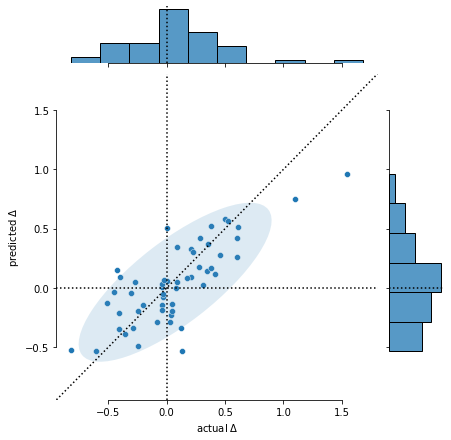

In [69]:
f = "log_NSPP_DIFF ~ log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + log_SLA_Mean_DIFF + CN_prevalence_2016 + AnTol_prevalence_2016 + SLA_prevalence_2016 + log_XRCOV_ALIENSPP_DIFF + d_estuarine_2016 + d_woody_2016 + d_disturb_I_2011 + d_disturb_M_2011 + PMEAN_PT_2011 + TMEAN_PT_2011 + aet_mean_2011 + def_mean_2011"

d = data=flatten_columns(sites)
y, X = patsy.dmatrices(f, d, return_type="dataframe")

results = smf.ols(formula=f, data=d).fit(cov_type="HC0")

print("\n", results.summary2())
print("\n", "Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
print("\n", "Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))
print("\n", "Sorted by statistical significance")
print(pd.concat([results.params.rename("params"), results.pvalues.rename("pvalues")], axis=1).sort_values("pvalues", ascending=True))

dmat = pd.concat([y, X], axis="columns").dropna()
dmat_scaled = dmat.copy()
dmat_scaled[:] = scale(dmat_scaled[:])
reg_L1 = sm.OLS(endog=dmat_scaled.iloc[:, 0], exog=dmat_scaled.iloc[:, 1:]).fit_regularized(method="sqrt_lasso")
print("\n", "regularized absolute coefficients")
print(reg_L1.params.abs().sort_values(ascending=False))

# test predictive model
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# join results and plot
g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=0.25))
g.ax_joint.set_xlabel("actual $\Delta$")
g.ax_joint.set_ylabel("predicted $\Delta$")
g.ax_joint.axhline(y=0, color="black", linestyle=":")
g.ax_joint.axvline(x=0, color="black", linestyle=":")
g.ax_marg_x.axvline(x=0, color="black", linestyle=":")
g.ax_marg_y.axhline(y=0, color="black", linestyle=":")
plt.show()


                      Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.185   
Dependent Variable:    ShannonDiv_DIFF     AIC:                   240.7240
Date:                  2021-07-13 23:05    BIC:                   291.8113
No. Observations:      180                 Log-Likelihood:        -104.36 
Df Model:              15                  F-statistic:           4.343   
Df Residuals:          164                 Prob (F-statistic):    8.38e-07
R-squared:             0.253               Scale:                 0.20491 
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  -0.4257   0.2943 -1.4467 0.1480 -1.0025  0.1511
log_CN_Ratio_DIFF          -0.2745   0.0868 -3.1624 0.0016 -0.4447 -0.1044
log_AnaerobicTol_Mean_DIFF -0.1754   0.0679 -

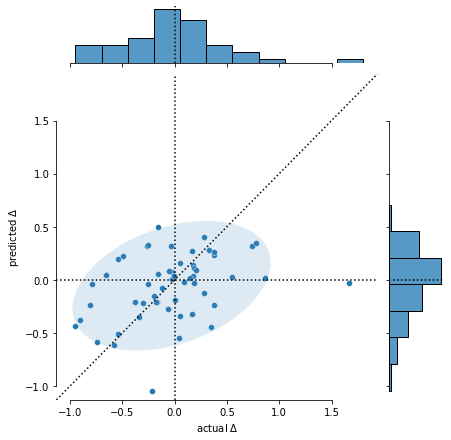

In [68]:
f = "ShannonDiv_DIFF ~ log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + log_SLA_Mean_DIFF + CN_prevalence_2016 + AnTol_prevalence_2016 + SLA_prevalence_2016 + log_XRCOV_ALIENSPP_DIFF + d_estuarine_2016 + d_woody_2016 + d_disturb_I_2011 + d_disturb_M_2011 + PMEAN_PT_2011 + TMEAN_PT_2011 + aet_mean_2011 + def_mean_2011"

d = data=flatten_columns(sites)
y, X = patsy.dmatrices(f, d, return_type="dataframe")

results = smf.ols(formula=f, data=d).fit(cov_type="HC0")
print("\n", results.summary2())
print("\n", "Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
print("\n", "Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))
print("\n", "Sorted by statistical significance")
print(pd.concat([results.params.rename("params"), results.pvalues.rename("pvalues")], axis=1).sort_values("pvalues", ascending=True))

dmat = pd.concat([y, X], axis="columns").dropna()
dmat_scaled = dmat.copy()
dmat_scaled[:] = scale(dmat_scaled[:])
reg_L1 = sm.OLS(endog=dmat_scaled.iloc[:, 0], exog=dmat_scaled.iloc[:, 1:]).fit_regularized(method="sqrt_lasso")
print("\n", "regularized absolute coefficients")
print(reg_L1.params.abs().sort_values(ascending=False))

# test predictive model
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# join results and plot
g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=0.25))
g.ax_joint.set_xlabel("actual $\Delta$")
g.ax_joint.set_ylabel("predicted $\Delta$")
g.ax_joint.axhline(y=0, color="black", linestyle=":")
g.ax_joint.axvline(x=0, color="black", linestyle=":")
g.ax_marg_x.axvline(x=0, color="black", linestyle=":")
g.ax_marg_y.axhline(y=0, color="black", linestyle=":")
plt.show()

# regression output with different sets of variables

In [79]:
d = flatten_columns(sites)

y_vars = ["log_NSPP_DIFF", "ShannonDiv_DIFF"]

X_core_DIFF = d[["log_CN_Ratio_DIFF", "log_AnaerobicTol_Mean_DIFF", "log_SLA_Mean_DIFF", "log_XRCOV_ALIENSPP_DIFF"]]
X_prev = d[["CN_prevalence_2016", "AnTol_prevalence_2016", "SLA_prevalence_2016"]]
X_cat = d[["d_estuarine_2016", "d_woody_2016"]] 
X_dist = d[["d_disturb_I_2011", "d_disturb_M_2011"]]
X_clim = d[["PMEAN_PT_2011", "TMEAN_PT_2011"]]
X_tc = d[["aet_mean_2011", "def_mean_2011"]]

# X_core_2016 = d[["log_CN_Ratio_2016", "log_AnaerobicTol_Mean_2016", "log_SLA_Mean_2016", "log_XRCOV_ALIENSPP_2016"]]
# X_cat = pd.get_dummies(d["WetlandCat_2011"], prefix="cat")
# X_eco = pd.get_dummies(d["ecoregion"], prefix="eco")

models = {
        "AT":   [d["log_AnaerobicTol_Mean_DIFF"]],
        "CN":   [d["log_CN_Ratio_DIFF"]],
        "SLA":  [d["log_SLA_Mean_DIFF"]],
        "XRC":  [d["log_XRCOV_ALIENSPP_DIFF"]],
        "base": [X_core_DIFF],
        "prev": [X_core_DIFF, X_prev],
        "cats": [X_core_DIFF, X_cat],
        "dist": [X_core_DIFF, X_dist],
        "clim": [X_core_DIFF, X_clim],
        "tc":   [X_core_DIFF, X_tc],
        "all":  [X_core_DIFF, X_prev, X_cat, X_dist, X_clim, X_tc], 
}

ys = {i: d[i] for i in y_vars}
Xs = {j: pd.concat(models[j], axis="columns") for j in models}

def exec_model(y: pd.Series, X: pd.DataFrame):
    dmat = pd.concat([y, X], axis="columns").dropna()
    reg = sm.OLS(endog=dmat.iloc[:, 0], exog=dmat.iloc[:, 1:].assign(intercept=1)).fit(covtype="HC0")
    return reg #(reg.rsquared_adj, reg.params, reg.pvalues)

regs = pd.DataFrame([[exec_model(ys[i], Xs[j]) for j in Xs] for i in ys], index=ys, columns=Xs).stack().rename("model")
rsquareds = regs.apply(lambda x: x.rsquared).rename_axis(["y", "X"])
params = regs.apply(lambda x: x.params).rename_axis(["variable"], axis="columns").rename_axis(["y", "X"])
pvalues = regs.apply(lambda x: x.pvalues).rename_axis(["variable"], axis="columns").rename_axis(["y", "X"])
pvalues = pvalues.applymap(lambda x: f"**{x:0.2f}" if x<0.05 else f"{x:0.2f}").applymap(lambda x: "" if x=="nan" else x)

varnames = list(params.columns.drop("intercept")) + ["intercept"] + ["_outputs"]
varnames_dtype = pd.CategoricalDtype(categories=reversed(varnames), ordered=True)
params.columns = params.columns.astype(varnames_dtype)
pvalues.columns = pvalues.columns.astype(varnames_dtype)

(pd.concat([params.T.assign(output="coeff"), 
            pvalues.T.assign(output="P"), 
            pd.DataFrame(rsquareds.rename("_outputs")).T.assign(output="R2_adj")])
        .set_index(["output"], append=True)
        .sort_index(level=0, ascending=False)
        .fillna("")
        )

y                                 log_NSPP_DIFF          ... ShannonDiv_DIFF        
X                                            AT      CN  ...              tc     all
                           output                        ...                        
log_AnaerobicTol_Mean_DIFF coeff          -0.35          ...           -0.20   -0.18
                           P             **0.00          ...          **0.00  **0.00
log_CN_Ratio_DIFF          coeff                  -0.24  ...           -0.21   -0.27
                           P                     **0.00  ...          **0.00  **0.00
log_SLA_Mean_DIFF          coeff                         ...            0.01    0.05
                           P                             ...            0.82    0.32
log_XRCOV_ALIENSPP_DIFF    coeff                         ...            0.02    0.03
                           P                             ...            0.18    0.08
CN_prevalence_2016         coeff                         ...                    0.02
                           P                             ...                    0.93
AnTol_prevalence_2016      coeff                         ...                    0.30
                           P                             ...                    0.19
SLA_prevalence_2016        coeff                         ...                   -0.33
                           P                             ...                    0.07
d_estuarine_2016           coeff                         ...                    0.13
                           P                             ...                    0.32
d_woody_2016               coeff                         ...                    0.02
                           P                             ...                    0.85
d_disturb_I_2011           coeff                         ...                    0.06
                           P                             ...                    0.60
d_disturb_M_2011           coeff                         ...                    0.13
                           P                             ...                    0.26
PMEAN_PT_2011              coeff                         ...                    0.00
                           P                             ...                    0.79
TMEAN_PT_2011              coeff                         ...                    0.01
                           P                             ...                    0.29
aet_mean_2011              coeff                         ...           -0.00   -0.00
                           P                             ...            0.91    0.26
def_mean_2011              coeff                         ...           -0.00   -0.00
                           P                             ...            0.40    0.27
intercept                  coeff           0.14   -0.25  ...           -0.21   -0.43
                           P             **0.00  **0.00  ...            0.21    0.15
_outputs                   R2_adj          0.33    0.17  ...            0.19    0.25

[33 rows x 22 columns]

- negative relationship between $\Delta AnaerobicTol$ and $\Delta NSPP$
- negative relationship between $\Delta SLA$ and $\Delta NSPP$
- negative relationship between $\Delta CN Ratio$ and $\Delta NSPP$
- all effects weaker after controlling for wetland type and prevalences
- estuarine sites had a less negative / more positive $\Delta NSPP$ on average
- negative relationship between $CN_{prevalence}$ and $\Delta NSPP$

...

- negative relationship between $\Delta AnaerobicTol$ and $\Delta ShannonDiv$
- negative relationship between $\Delta SLA$ and $\Delta ShannonDiv$
- negative relationship between $\Delta CN Ratio$ and $\Delta ShannonDiv$






# Model selection via cross validation

In [92]:
from itertools import combinations
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import KFold

cv = KFold(n_splits=3, shuffle=True, random_state=47) # KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit, etc.
scoring = ["r2", "neg_root_mean_squared_error", "neg_median_absolute_error"]

models = {
    "OLS": LinearRegression(fit_intercept=True, normalize=True, copy_X=True),
}

y_vars = ["log_NSPP_DIFF", "ShannonDiv_DIFF"]
X_vars = ["log_CN_Ratio_DIFF", "log_AnaerobicTol_Mean_DIFF", "log_SLA_Mean_DIFF", "log_XRCOV_ALIENSPP_DIFF",
          "CN_prevalence_2016", "AnTol_prevalence_2016", "SLA_prevalence_2016",
          "d_estuarine_2016", "d_woody_2016",
          "d_disturb_I_2011", "d_disturb_M_2011",
          "PMEAN_PT_2011", "TMEAN_PT_2011",
          "aet_mean_2011", "def_mean_2011",
          ]
X_combos = reduce(lambda x, y: x + y, [list(combinations(X_vars, r=i)) for i in range(1, len(X_vars) + 1)])
print(f"testing {len(X_combos)} combinations of {len(X_vars)} variables with {len(models)} models")

for y_var in y_vars:

    print("\n", y_var)
    df = flatten_columns(sites)[[y_var] + X_vars].dropna()

    out = {}
    for m in models:
        for c in X_combos:
            selected_vars = list(c)
            y = df[y_var]
            X = df[selected_vars]
            scores = cross_validate(models[m], X, y, cv=cv, scoring=scoring, return_train_score=False)
            out[(m, c)] = scores

    cv_means = pd.DataFrame(out).rename_axis("metric", axis=0).rename_axis(["model", "variables"], axis=1).T.applymap(np.mean)
    cv_means_scored = cv_means.sort_values("test_neg_root_mean_squared_error", ascending=False)
    print(cv_means_scored["test_neg_root_mean_squared_error"].head(20)) # these are the best-scoring model combinations

    # run OLS with the best-scoring model combination
    best_X_vars = list(cv_means_scored.index[0][1])
    results = sm.OLS(endog=df[y_var], exog=df[best_X_vars]).fit(cov_type="HC0")
    print(results.summary2())

testing 32767 combinations of 15 variables with 1 models

 log_NSPP_DIFF
model  variables                                                                                                                                                                                                                                
OLS    (log_CN_Ratio_DIFF, log_AnaerobicTol_Mean_DIFF, log_SLA_Mean_DIFF, log_XRCOV_ALIENSPP_DIFF, CN_prevalence_2016, AnTol_prevalence_2016, d_estuarine_2016, d_disturb_M_2011, PMEAN_PT_2011, TMEAN_PT_2011, def_mean_2011)                     -0.28
       (log_CN_Ratio_DIFF, log_AnaerobicTol_Mean_DIFF, log_SLA_Mean_DIFF, log_XRCOV_ALIENSPP_DIFF, CN_prevalence_2016, AnTol_prevalence_2016, d_estuarine_2016, d_disturb_M_2011, TMEAN_PT_2011, def_mean_2011)                                    -0.28
       (log_CN_Ratio_DIFF, log_AnaerobicTol_Mean_DIFF, log_SLA_Mean_DIFF, log_XRCOV_ALIENSPP_DIFF, CN_prevalence_2016, AnTol_prevalence_2016, d_estuarine_2016, d_woody_2016, d_disturb_M_20

# Dataset 2

additional data from 2011 to test as covariates of plant diversity change and trait change for NWCA wetlands

REF_NWCA - this is the disturbance level category (L - least, I - intermediate, M- most)

XABCOV_AC - invasive cover in 2011 (we have that already and, as we had talked, should look at its change as well which we should have in the earlier table)

variables starting with column AK - elevation, climate etc and their names are largely self-explanatory.  a lot of those would be correlated among themselves; however, they are also the ones that are less likely to change year-to-year. some measures there are very long-term means of temp. & precip and are more useful as proxies for "general" climate to test as covariates. When I put together the remote sensing metrics for the next week's meeting, I will also try to get some changes in climate data from GEE that are more year-specific and download those as well, [DAYMET](https://daymet.ornl.gov/web_services) will be likely most useful to us. If I am not able to do it by next Thu, I might ask for your help to get those, but let's discuss it then.